<a href="https://colab.research.google.com/github/piru24/DL_Ass_Sample/blob/main/DS_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd

df = pd.read_csv(
    "/content/IMDB Dataset.csv",
    escapechar='\\',
    engine='python',
    on_bad_lines='skip',  # skips malformed lines
    skip_blank_lines=True
)

print(df.shape)


# Remove null values
df = df.dropna(subset=['review', 'sentiment'])

# Remove duplicate reviews
df = df.drop_duplicates(subset='review')

print("After Cleaning - Dataset shape:", df.shape)

# Encode labels: positive=1, negative=0
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Check data balance
print(df['sentiment'].value_counts())
df.head()

(11038, 2)
After Cleaning - Dataset shape: (11018, 2)
sentiment
0    5513
1    5505
Name: count, dtype: int64


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


/tmp/ipython-input-3115095704.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='Set2')


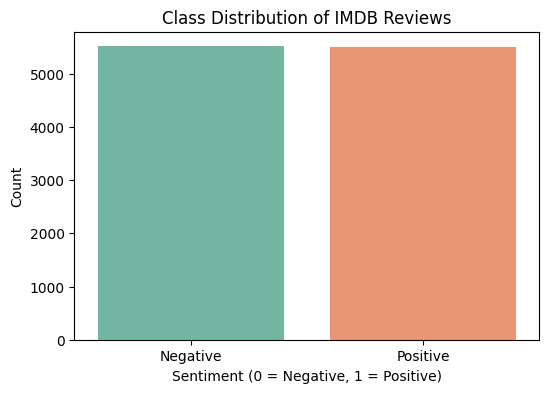

Total Reviews: 11018
Positive Reviews: 5505
Negative Reviews: 5513


In [23]:
# ===============================
# Step 1.5 (a): Class Distribution
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df, palette='Set2')
plt.title("Class Distribution of IMDB Reviews")
plt.xlabel("Sentiment (0 = Negative, 1 = Positive)")
plt.ylabel("Count")
plt.xticks([0,1], ['Negative', 'Positive'])
plt.show()

# Print balance details
print("Total Reviews:", len(df))
print("Positive Reviews:", df['sentiment'].sum())
print("Negative Reviews:", len(df) - df['sentiment'].sum())


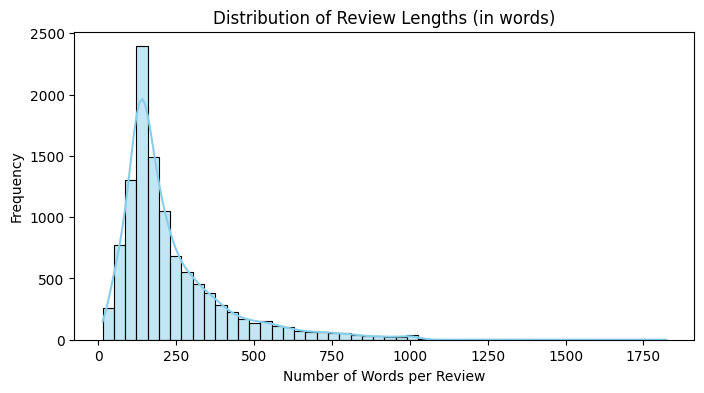

Average Review Length: 235


In [24]:
# ===============================
# Step 1.5 (b): Review Length Distribution
# ===============================
# Calculate review lengths
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,4))
sns.histplot(df['review_length'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Review Lengths (in words)")
plt.xlabel("Number of Words per Review")
plt.ylabel("Frequency")
plt.show()

print("Average Review Length:", int(df['review_length'].mean()))


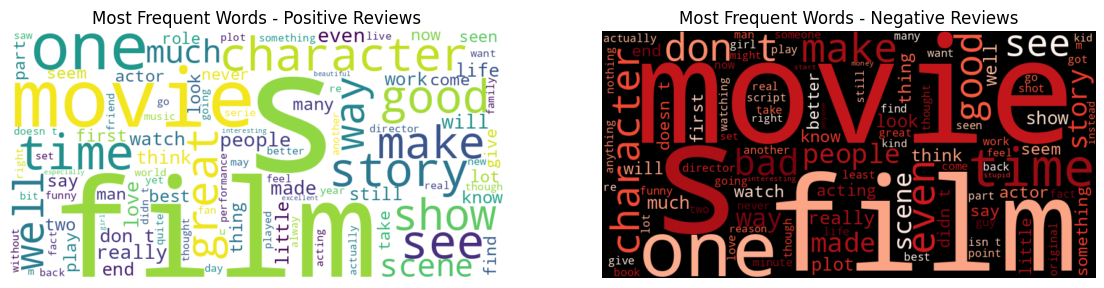

In [25]:
# ===============================
# Step 1.5 (c): Word Clouds for Positive & Negative Reviews
# ===============================
from wordcloud import WordCloud

# Positive reviews
positive_text = " ".join(df[df['sentiment'] == 1]['review'])
negative_text = " ".join(df[df['sentiment'] == 0]['review'])

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
wc_pos = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(positive_text)
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words - Positive Reviews")

plt.subplot(1,2,2)
wc_neg = WordCloud(width=800, height=400, background_color='black', colormap='Reds', max_words=100).generate(negative_text)
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words - Negative Reviews")

plt.show()


In [26]:
# ===============================
# Step 2: Text Cleaning
# ===============================
import re

def clean_text(text):
    text = re.sub(r"<.*?>", " ", text)      # Remove HTML tags
    text = re.sub(r"[^a-zA-Z]", " ", text)  # Keep only letters
    text = text.lower()                     # Convert to lowercase
    return text

df['review'] = df['review'].apply(clean_text)
df.head()


,review,sentiment,review_length
0,one of the other reviewers has mentioned that ...,1,313
1,a wonderful little production the filming t...,1,160
2,i thought this was a wonderful way to spend ti...,1,167
3,basically there s a family where a little boy ...,0,133
4,petter mattei s love in the time of money is...,1,228


In [27]:
# ===============================
# Step 3: Train-Test Split
# ===============================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=42
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 8814
Testing samples: 2204


In [28]:
# ===============================
# Step 4: Tokenization + Padding
# ===============================
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

NUM_WORDS = 10000
MAXLEN = 300

tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token="<UNK>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to fixed length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAXLEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAXLEN)

print("Padded Training shape:", X_train_pad.shape)
print("Padded Testing shape:", X_test_pad.shape)


Padded Training shape: (8814, 300)
Padded Testing shape: (2204, 300)


In [29]:
# ===============================
# Step 5: Build Bidirectional LSTM Model
# ===============================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

model = Sequential([
    Embedding(input_dim=NUM_WORDS, output_dim=128, input_length=MAXLEN),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [32]:
# ===============================
# Step 6: Train the Model
# ===============================
history = model.fit(
    X_train_pad,
    y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)


Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 111s 893ms/step - accuracy: 0.9579 - loss: 0.1449 - val_accuracy: 0.7937 - val_loss: 0.6448
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 95s 768ms/step - accuracy: 0.9736 - loss: 0.0905 - val_accuracy: 0.8095 - val_loss: 0.7201
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 102s 818ms/step - accuracy: 0.9881 - loss: 0.0371 - val_accuracy: 0.8231 - val_loss: 0.7975
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 98s 790ms/step - accuracy: 0.9940 - loss: 0.0214 - val_accuracy: 0.7812 - val_loss: 0.8447
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 96s 773ms/step - accuracy: 0.9946 - loss: 0.0241 - val_accuracy: 0.8186 - val_loss: 0.8685
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 103s 823ms/step - accuracy: 0.9904 - loss: 0.0333 - val_accuracy: 0.8197 - val_loss: 0.8556
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 137s 785ms/step - accuracy: 0.9989 - loss: 0.0055 - val_accuracy: 0.8265 - val_loss: 0.8909
Epoch 8/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 147s 820ms/step - accuracy: 0.9999 - lo

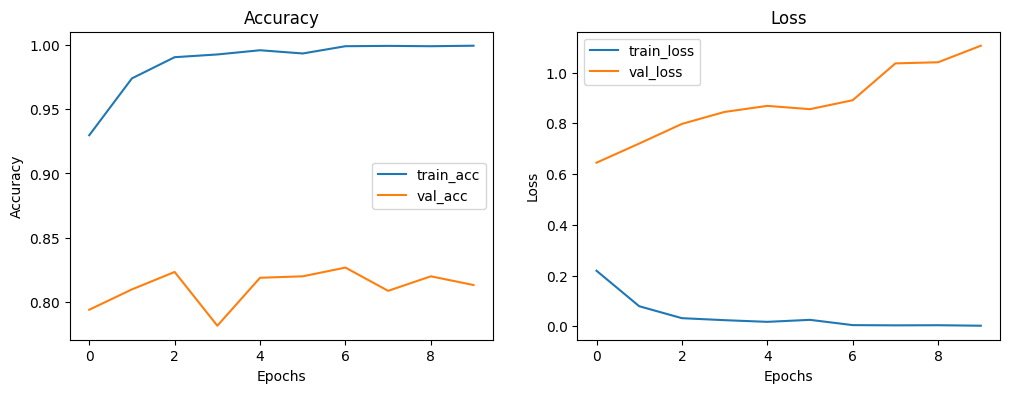

In [33]:
# ===============================
# Step 7: Plot Training History
# ===============================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.8145 - loss: 0.9824
Test Accuracy: 0.8153
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.77      0.80      1080
           1       0.80      0.86      0.83      1124

    accuracy                           0.82      2204
   macro avg       0.82      0.81      0.81      2204
weighted avg       0.82      0.82      0.81      2204



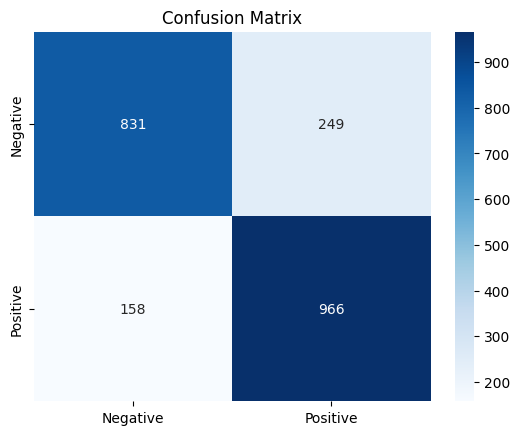

In [34]:
# ===============================
# Step 8: Evaluate Model
# ===============================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

loss, acc = model.evaluate(X_test_pad, y_test, verbose=1)
print(f"Test Accuracy: {acc:.4f}")

# Predictions
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.show()


In [35]:
# ===============================
# Step 9: Predict Custom Reviews
# ===============================
def predict_review(review_text):
    text = re.sub(r"<.*?>", " ", review_text)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.lower()

    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=MAXLEN)
    pred_prob = model.predict(pad)[0][0]
    label = "Positive" if pred_prob > 0.5 else "Negative"

    return label, pred_prob

# Example 1
review = "The movie was amazing! I loved the acting and the storyline."
label, prob = predict_review(review)
print(f"Predicted Sentiment: {label} (Probability: {prob:.2f})")

# Example 2
review = "I did not enjoy this movie at all. It was boring and too long."
label, prob = predict_review(review)
print(f"Predicted Sentiment: {label} (Probability: {prob:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Predicted Sentiment: Positive (Probability: 1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Predicted Sentiment: Negative (Probability: 0.11)
